In [1]:
import networkx as nx
import pickle
import copy
import heapq

G = nx.DiGraph()
with open('data/graph_all.pickle', 'rb') as f:
    G = pickle.load(f)
modules_info={}
with open('data/modules_info.pickle', 'rb') as f:
    modules_info = pickle.load(f)

lowercase_nodes = set(node.lower() for node in G.nodes)
assert(len(G.nodes) == len(lowercase_nodes))

print(f"nodes:{len(G.nodes)},edges:{len(G.edges)}")

nodes:1115,edges:12867


### 第一步：寻找最大的强连通分量，形成新的图

In [2]:
sccs = list(nx.strongly_connected_components(G))
largest_scc = max(sccs, key=len)

new_G = nx.DiGraph()

for node in G.nodes:
    if node not in largest_scc:
        new_G.add_node(node)

new_G.add_node("BigComponent")

for u, v in G.edges:
    if u in largest_scc and v in largest_scc:
        continue
    elif u in largest_scc:
        new_G.add_edge("BigComponent", v)
    elif v in largest_scc:
        new_G.add_edge(u, "BigComponent")
    else:
        new_G.add_edge(u, v)

old_G=G
G=new_G
print(f"nodes:{len(G.nodes)},edges:{len(G.edges)}")

nodes:736,edges:1850


### 第二步：破除自环与简单环，验证是否为DAG

In [3]:
self_loops = list(nx.selfloop_edges(G))
print(f"self loops:{len(self_loops)}")
G.remove_edges_from(self_loops)
cycles = list(nx.simple_cycles(G))
print(f"simple cycles:{cycles}")
for cycle in cycles:
    if len(cycle) == 1:
        continue
    
    in_degrees = [G.in_degree(node) for node in cycle]
    
    end_node = cycle[in_degrees.index(max(in_degrees))]
    
    cycle_copy = cycle[:]
    while cycle_copy[-1] != end_node:
        cycle_copy = cycle_copy[1:] + [cycle_copy[0]]
    
    for i in range(len(cycle_copy) - 1):
        if G.has_edge(cycle_copy[i + 1], cycle_copy[i]):
            G.remove_edge(cycle_copy[i + 1], cycle_copy[i])
print(f"nodes:{len(G.nodes)},edges:{len(G.edges)}")

assert(nx.is_directed_acyclic_graph(G))

self loops:249
simple cycles:[['TextureShare', 'VirtualProduction'], ['WebBrowserTexture', 'WebBrowser']]
nodes:736,edges:1599


### 第三步：依赖约简 构造依赖函数

In [4]:
H = nx.algorithms.dag.transitive_reduction(G)
nx.write_gexf(H, "data/graph_wpd_tr.gexf")
print(f"nodes:{len(H.nodes)},edges:{len(H.edges)}")

def get_all_successors(graph, node):
    """获取节点的所有直接和间接依赖"""
    seen = set()
    stack = [node]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(graph.successors(node))
    return seen

def get_all_predecessors(graph, node):
    """获取所有直接和间接依赖这个节点的节点"""
    seen = set()
    stack = [node]
    while stack:
        node = stack.pop()
        if node not in seen:
            seen.add(node)
            stack.extend(graph.predecessors(node))
    return seen

nodes:736,edges:921


### （可选）：生成拓扑排序后的文件与BigComponent信息文件

In [5]:
import heapq

def inverse_topological_sort(graph):
    # 初始化优先队列
    queue = []
    for node in graph.nodes:
        predecessors = get_all_predecessors(graph, node)
        successors = get_all_successors(graph, node)
        heapq.heappush(queue, (-len(predecessors), node, len(predecessors)-1, len(successors)-1))

    # 进行拓扑排序
    while queue:
        _, node, preds, succs = heapq.heappop(queue)
        yield node, preds, succs

def desc(node):
    if node=="BigComponent": return node
    if "Description" in modules_info[node] and modules_info[node]["Description"]:
        return f'{node}({modules_info[node]["Description"]})'
    return node
        
def write_to_file(graph, file_path):
    with open(file_path, "w") as f:
        for node, preds, succs in inverse_topological_sort(graph):
            f.write(f"{node}, pred:{preds}, succs:{succs}\n")

write_to_file(H, 'data/topology_all.txt')


node_list = largest_scc
data = [(node, old_G.in_degree(node), old_G.out_degree(node)) for node in node_list]
data.sort(key=lambda x: x[1], reverse=True)

with open('data/BigComponent.txt', 'w') as f:
    for node, in_degree, out_degree in data:
        f.write(f"{desc(node)}, In-degree: {in_degree}, Out-degree: {out_degree}\n")

### 查看依赖&删除模块/恢复模块

In [5]:
import os
import shutil
import logging
import json
import matplotlib.pyplot as plt

# Info logger that logs to a file
info_logger = logging.getLogger('info_logger')
info_logger.setLevel(logging.INFO)
info_handler = logging.FileHandler('logs/filesystem.log')
info_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
info_logger.addHandler(info_handler)

# Error logger that logs both to console and a file
error_logger = logging.getLogger('error_logger')
error_logger.setLevel(logging.ERROR)
error_handler = logging.FileHandler('logs/error.log')
error_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
error_logger.addHandler(error_handler)
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter('%(asctime)s - %(levelname)s - %(message)s'))
error_logger.addHandler(console_handler)

class FileSystem:

    def __init__(self, trash_dir='trash', trash_log_file='logs/trash_log.json'):
        self.trash_dir = trash_dir
        self.trash_log_file = trash_log_file

        if os.path.exists(trash_log_file): 
            with open(trash_log_file, 'r') as f:
                self.trash = json.load(f)
        else:
            self.trash = {}

    def delete(self, nodes):
        for node in nodes:
            try:
                dir_path = modules_info[node]["Dir"]
            except KeyError:
                error_logger.error(f'No directory found for node: {node}')
                continue 
            if os.path.exists(dir_path):
                trash_path = os.path.join(self.trash_dir, os.path.basename(dir_path))
                shutil.move(dir_path, trash_path)
                self.trash[node] = {
                    "dir_path": dir_path,
                    "trash_path": trash_path
                }
                info_logger.info(f'Deleted directory: {dir_path}, moved to: {trash_path}')
        self.save_trash_log()

    def restore(self):
        if not self.trash:
            info_logger.info('No directories to restore.')
            return

        # Restore the latest directory.
        node, paths = list(self.trash.items())[-1]
        self.restore_specific(node)

    def restore_specific(self, node):
        paths_info = self.trash.get(node)
        if not paths_info:
            error_logger.error(f'No directory info found for node: {node}')
            return

        dir_path = paths_info["dir_path"]
        trash_path = paths_info["trash_path"]

        # Check if dir_path already exists
        if os.path.exists(dir_path):
            error_logger.error(f'Target directory already exists: {dir_path}. Restoration skipped for node: {node}')
            return

        if os.path.exists(trash_path):
            try:
                shutil.move(trash_path, dir_path)
                info_logger.info(f'Restored directory: {dir_path} from: {trash_path}')
                del self.trash[node]
                self.save_trash_log()
            except shutil.Error as e:
                error_logger.error(f'Error restoring directory: {e}')
    
    def check_existence_and_print(self):
        existing_dirs = {}
        for node, paths_info in self.trash.items():
            dir_path = paths_info["dir_path"]
            if os.path.exists(dir_path):
                print(f"Node: {node}, Dir Path: {dir_path}")
                existing_dirs[node] = dir_path
        return existing_dirs
    
    def save_trash_log(self):
        with open(self.trash_log_file, 'w') as f:
            json.dump(self.trash, f)
            
fs = FileSystem()

def observe(node):
    nodes=get_all_predecessors(H,node)
    HH=H.subgraph(nodes)
    pos = nx.spring_layout(HH)
    node_colors = ["#0080f0" for node in HH.nodes()]
    node_colors[list(HH.nodes()).index(node)] = 'red'
    nx.draw(HH, pos, with_labels=True, node_size=150,node_color=node_colors,font_size=8)
    plt.show()
    print(",".join(nodes))
    return nodes

### 准备就绪！

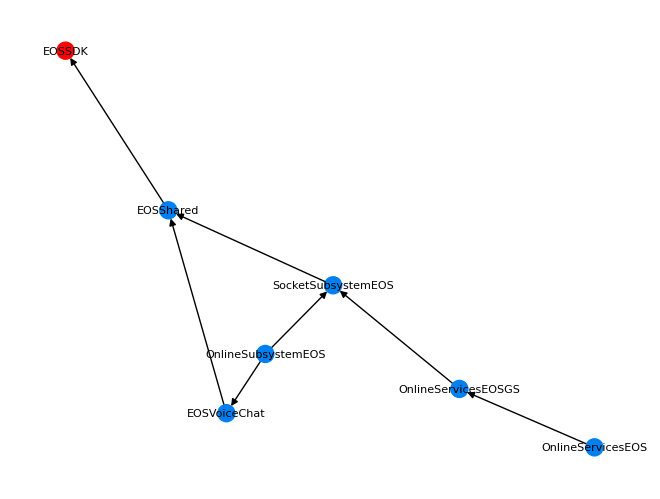

EOSShared,OnlineServicesEOSGS,SocketSubsystemEOS,OnlineSubsystemEOS,OnlineServicesEOS,EOSVoiceChat,EOSSDK


In [6]:
cur_node="EOSSDK"
nodes=observe(cur_node)

In [8]:
# fs.delete(nodes)

In [8]:
# fs.restore()

In [6]:
with open("D0825.txt", "r") as file:
    nodes = [line.strip() for line in file]

len(nodes)

38

In [7]:
fs.delete(nodes)

In [10]:
fs.restore_specific("Online")

In [8]:
fs.delete(["DatasmithGLTFImporter","Editor"])

In [8]:
recovered = fs.check_existence_and_print()

Node: ANGLE, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Source\ThirdParty\ANGLE
Node: ActorPalette, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Experimental\ActorPalette
Node: ActorSequence, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\MovieScene\ActorSequence
Node: Adjust, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Runtime\Analytics\Adjust
Node: AjaMedia, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Media\AjaMedia
Node: AlembicHairImporter, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Importers\AlembicHairImporter
Node: AndroidCamera, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Media\AndroidCamera
Node: AndroidDeviceProfileSelector, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Runtime\AndroidDeviceProfileSelector
Node: AndroidFileServer, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Runtime\AndroidFileServer
Node: AndroidMedia, Dir Path: E:\UnrealEngine-5.1.0-release\Engine\Plugins\Media\AndroidMedi

In [9]:
len(recovered)

186